# Pytorchサンプルコード with Cifar10

これから記載するPytorchのサンプルコードは、cifar10という画像データセットを学習し、<br>
入力画像がどのような画像か？をラベリング（ラベルは一つのみ）するモデルを構築します。

また本チュートリアル作成時のPytorchのバージョンは、v1.5.1となります。

## ベースとなるチュートリアル

本チュートリアルは下記のPytorchのチュートリアルをベースに作成しています。<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


## Cifar10について

Cifar10は画像データセットになっていて、画像サイズは32*32(RGB)となります。<br>
画像の種類は10種類(後述のコードに記載)となっております。<br>

<br>
よって、一枚の画像のデータサイズとしては、32*32*3となります。

## ニューラルネットワークを構築する

今回はCifar10のデータセットを利用して、シンプルなニューラルネットワーク（多層パーセプトロン）を構築してみます。<br>
前述したように、ニューラルネットワークを構築するために以下のステップが必要になります。

1. データセットの作成
2. ニューラルネットワークの定義
3. ニューラルネットワークの学習

上記ステップでどのような実装が必要なのか？を具体的にPytorchを利用して、実装していきます。

## 1. データセットの作成

まずはCifar10のデータセットを作成していきます。<br>
Pytorchや他のメジャーなDNNフレームワークでは、Cifar10などのような有名どころなデータセットは標準で実装されていることが多いです。<br>

In [1]:
# pytorchの関連ライブラリをインポートする
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Cifar10のデータセットの作成

## Cifar10のデータセットをロードする際に行う前処理を定義
### ToTensorは、PIL Imageやndarray(numpy)のデータを, channel * height * widthに変換する処理（Pytorchで扱いやすいデータの型にしていると考えれば良い）
### Normalizeは、各列の平均と標準偏差を指定して、正規化を行う処理（下記だと、channel方向ならば、平均0.5, 標準偏差0.5でデータを正規化する）
### ToTensor -> https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

## 学習用データセットの定義
### batch_size=4のため、4枚の画像毎に学習ステップを一回実施
### shuffle=Trueだと、1epochごとにデータをシャッフルする
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

## テストデータセットの定義
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

## 分類ラベルの定義
### 元々cifar10では分類クラスが決まっている（10種類 -> だからcifar10）
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


shape is (3, 36, 138)


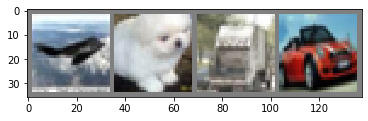

plane   dog truck   car


In [3]:
# 画像を描画してみます
## 平均0.5, 標準偏差0.5に設定しているため、画像描画時は元のデータに戻す処理を加えてます

import matplotlib.pyplot as plt
import numpy as np

# PytorchのTensorから画像を描画するための関数
def imshow(img):
    img = img / 2 + 0.5  # Normalizeしたデータを元に戻している
    npimg = img.numpy()
    print("shape is {}".format(npimg.shape))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # PIL Imageで読み込む際には、Height * Width * Channelにデータの順序を戻す必要があるため、Transposeで配列順序を入れ替えています
    plt.show()


# 学習用のDataLoaderから画像を試しに1バッチ分（= 4枚）取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示を実施
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. ニューラルネットワークの定義

データセットの準備が出来たため、次はニューラルネットワーク（モデル）の定義を行います。<br>
今回は以下のような多層パーセプトロンを定義します。

* 入力サイズは、32*32*3 (Cifar10の一枚の画像サイズが32*32*3のため）
* 隠れ層1（FCレイヤー）は、32*32*3 -> 720次元に変換
* 隠れ層2（FCレイヤー）は、720次元 -> 84に変換
* 隠れ層3（FCレイヤー）は、84 -> 10に変換
* 損失関数をクロスエントロピー、最適化関数をSGD（確率的勾配降下法）を設定

最後が10なのは、今回のCifar10だと10種類の画像への分類タスクのため、どの種類である可能性が高いか？をスコアとして出すようなモデルとしています。

In [4]:
# Cifar10の画像から、その画像が何か？（どのラベルに該当するか？）を判定するモデルを構築します
import torch.nn as nn
import torch.nn.functional as F

# TODO : モデルに関する説明の実施
class FCNet(nn.Module):
    def __init__(self, width=32, height=32, channel=3):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(width * height * channel, 720)
        self.fc2 = nn.Linear(720, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 入力画像には、Tensor(Channel, Width, Height)が渡って来るため、FCレイヤーで計算できるように1次元に変換します(= Flatten)
        ## Flattenをやらずに、DataSet作成時に1次元なデータセットに変換する処理を実施してもOKです
        ## transforms.LinearTransformation を利用することになります( https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.LinearTransformation )
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# RGBな画像のため、チャネル数は3となります
net = FCNet()

In [5]:
# 損失関数と最適化手法の設定を行います
## TODO : 損失関数と最適化手法の説明の実施

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3. ニューラルネットワークの学習

モデル構造の定義が出来ましたので、次にデータセットを利用して、モデルを学習していきます。<br>
前述してますが、モデルの学習では、バッチサイズ毎に以下の学習ステップを行なっています。

1. 順伝播処理の実施（入力層にデータを入れて、出力層から結果を出力）
1. 誤差の算出（出力結果を何かしらのデータ（例えば、教師データなど）と比較して、損失関数から誤差を算出）
1. 誤差逆伝播の実施（出力層の誤差情報を、各層に対してフィードバック）
1. パラメーター最適化（各層の誤差情報を元に、パラメーターを最適化する。最適化関数を利用）

start training....
[1,  2000] loss: 1.910
[1,  4000] loss: 1.683
[1,  6000] loss: 1.633
[1,  8000] loss: 1.600
[1, 10000] loss: 1.570
[1, 12000] loss: 1.536
1 epoch loss : 1.649341494064331
[2,  2000] loss: 1.443
[2,  4000] loss: 1.451
[2,  6000] loss: 1.415
[2,  8000] loss: 1.412
[2, 10000] loss: 1.430
[2, 12000] loss: 1.409
2 epoch loss : 1.425745230615139
[3,  2000] loss: 1.302
[3,  4000] loss: 1.326
[3,  6000] loss: 1.315
[3,  8000] loss: 1.324
[3, 10000] loss: 1.323
[3, 12000] loss: 1.328
3 epoch loss : 1.319784034318924
[4,  2000] loss: 1.217
[4,  4000] loss: 1.241
[4,  6000] loss: 1.254
[4,  8000] loss: 1.255
[4, 10000] loss: 1.244
[4, 12000] loss: 1.226
4 epoch loss : 1.239098631336391
[5,  2000] loss: 1.136
[5,  4000] loss: 1.154
[5,  6000] loss: 1.156
[5,  8000] loss: 1.190
[5, 10000] loss: 1.160
[5, 12000] loss: 1.202
5 epoch loss : 1.1661830870452523
finish training....


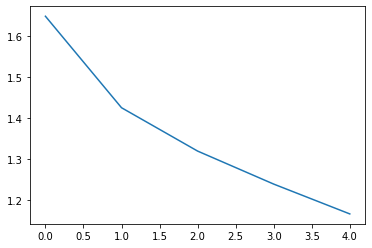

In [6]:
# 学習用のデータセットを用いて、モデルの学習を行います

# 1epochでデータセットに含まれる全データを利用して、一度学習処理をしたことになります。
# 例えば、5epochなら、全データを5回繰り返し利用して、学習したことになります。
print("start training....")
epoch_count = 5
epoch_losses = []
for epoch in range(1, epoch_count+1):
    # 1epochごとに全データを学習します
    ## バッチサイズごとに学習を実施し、損失（ロス）を算出します
    ## 損失結果を利用し、誤差逆伝播を行い、定義した最適化関数に応じた最適化処理（重み調整）を実施します
    train_loss = 0.0
    train_total_loss_in_1epoch = 0
    for i, data in enumerate(trainloader, 0):
        # バッチサイズ分の画像データがdataにラベル情報（cat, trainなど）と一緒に含まれています
        inputs, labels = data
        
        # 勾配情報（誤差逆伝播した際の差分情報）をバッチごとに初期化します
        ## 勾配情報は累積されるため、バッチサイズ単位で（勾配情報を利用して）最適化処理を行います。
        ## そのため、バッチサイズでの最適化処理が終われば、次のバッチサイズのデータで学習する前に勾配のリセットが必要となります。
        optimizer.zero_grad()

        # モデルの順伝播、誤差逆伝播、最適化処理を実施
        ## 1. 順伝播の実施
        outputs = net(inputs)
        ## 2. バッチサイズ分の損失を算出
        loss = criterion(outputs, labels)
        ## 3. 誤差逆伝播の実施
        loss.backward()
        ## 4. 最適化処理の実施
        optimizer.step()

        # 学習状況を可視化する
        ## ロスの状況を可視化する。今回の場合だと、2000バッチ（=> 4 * 2000 = 8000データごと）ごとにロスを表示する
        train_loss += loss.item()
        ## 1epchごとのロスを算出するために、1バッチごとのロスを蓄積させる
        train_total_loss_in_1epoch += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch, i + 1, train_loss / 2000))
            train_loss = 0
    epoch_losses.append(train_total_loss_in_1epoch/len(trainloader))
    print("{} epoch loss : {}".format(epoch, train_total_loss_in_1epoch/len(trainloader)))
plt.plot(epoch_losses)

# 学習状況を保存します
import os

save_folder = "result"
os.makedirs(save_folder, exist_ok=True)
plt.savefig(os.path.join(save_folder, "train_result_epoch_{}.png".format(epoch_count)))
print("finish training....")

In [7]:
# 学習済みとなったモデルを保存します
model_foder = "model"
os.makedirs(model_foder, exist_ok=True)
saved_model_path = os.path.join(model_foder, "cifar_fcnet_epoch{}.pth".format(epoch_count))
torch.save(net.state_dict(), saved_model_path)

## 学習したモデルの利用

構築したモデルを利用して、テストデータでの推論処理を試してみましょう。

shape is (3, 36, 138)


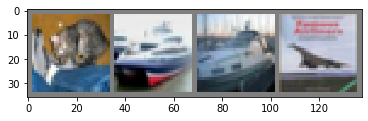

GroundTruth:    cat  ship  ship plane


In [8]:
# 作成したモデルを利用して、テストデータでも検証してみます
## まずはテストデータの中身を学習データと同様に表示してみます(1バッチ分の表示を行います)

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
## 学習済みモデルを復元しましょう

## 学習済みモデルのロードを行います
net = FCNet()
### OrderdDict形式（順序つき辞書形式）で,pathからパラメーター情報を取得する
param_dict = torch.load(saved_model_path)
### dict情報から、学習済みのモデルを復元する
net.load_state_dict(param_dict)

<All keys matched successfully>

In [10]:
## 次に1バッチ分のデータ（先ほど表示した画像）に対して、作成したモデルでの予測を試します
outputs = net(images)

### もっとも確度が高い予測ラベルのみを取得します
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat truck plane  bird


In [11]:
### 試しに分類時のスコアと、他にどのような候補があがったかをみてみましょう
scores, predicted = torch.topk(outputs, k=3, dim=1)
for i in range(len(outputs)):
    print("## {} ##".format(i))
    for score, candidate in zip(scores[i], predicted[i]):
        print("predicted candidate/score : {}:{}".format(classes[candidate], score))

## 0 ##
predicted candidate/score : cat:3.421053171157837
predicted candidate/score : dog:2.1333000659942627
predicted candidate/score : ship:0.8595173358917236
## 1 ##
predicted candidate/score : truck:5.852769374847412
predicted candidate/score : ship:5.1176323890686035
predicted candidate/score : car:4.105088710784912
## 2 ##
predicted candidate/score : plane:6.9501190185546875
predicted candidate/score : ship:4.630404472351074
predicted candidate/score : car:2.4512643814086914
## 3 ##
predicted candidate/score : bird:2.8647708892822266
predicted candidate/score : horse:2.7547714710235596
predicted candidate/score : plane:2.582412004470825


In [12]:
## 作成したモデルを利用して、テストデータに対して、精度を検証してみます
### 今回の精度検証では、TOP-1スコアでの精度検証となります。（画像分類タスクでは、TOP-1、TOP-5などのスコアがあったりします）
### TOP5の場合は、予測した結果、上位5個の分類結果内に正解ラベルがあれば、正しい分類とみなします。
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy Top1 of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy Top1 of the network on the 10000 test images: 53 %


In [13]:
### TOP3のケースでも結果を算出してみましょう
correct = 0
total = 0
top_k = 3
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.topk(outputs, k=top_k, dim=1)
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted[i]:
                correct += 1
print('Accuracy Top3 of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy Top3 of the network on the 10000 test images: 82 %


In [14]:
### 単純に全体の精度を出すだけでなく、どのラベルの精度が高いか？低いか？を検証してみましょう
class_correct = list(0. for i in range(len(classes)))
class_total   = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # squeeze（各次元で1要素しかない場合に、該当する次元を削除する）を実施して、Tensorの構造をベクトルへと修正
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 各ラベルの正答率を表示します
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 67 %
Accuracy of  bird : 36 %
Accuracy of   cat : 43 %
Accuracy of  deer : 36 %
Accuracy of   dog : 34 %
Accuracy of  frog : 61 %
Accuracy of horse : 65 %
Accuracy of  ship : 72 %
Accuracy of truck : 54 %


## 直近モデルでのcifar10の精度について

最後に直近のモデルでのcifar10データセットでの精度情報について、紹介いたします。<br>
[こちら](https://paperswithcode.com/sota/image-classification-on-cifar-10)のページに、cifar10データセットで上位のランキングとなっているモデル一覧が載っています。<br>
<br>
99％の精度のケースもあり、今回作成したモデルがいかに精度が低いかがわかります。